In [ ]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [4]:
df = pd.read_excel('output_clean.xlsx')
print(df.shape)  # (123, 8)
df.tail()

(67, 5)


,Unnamed: 0,date,rate_rus,dollar,rate_us
62,62,2023-03-01,7.5,74.8932,4.625
63,63,2023-04-01,7.5,77.3233,4.875
64,64,2023-05-01,7.5,80.5093,4.875
65,65,2023-06-01,7.5,80.9942,5.125
66,66,2023-07-01,8.5,88.3844,5.125


In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('date', axis = 1)
df.head()

,rate_rus,dollar,rate_us
0,7.75,57.6002,1.375
1,7.50,56.1840,1.375
2,7.25,56.3742,1.375
3,7.25,57.2649,1.625
4,7.25,61.9997,1.625


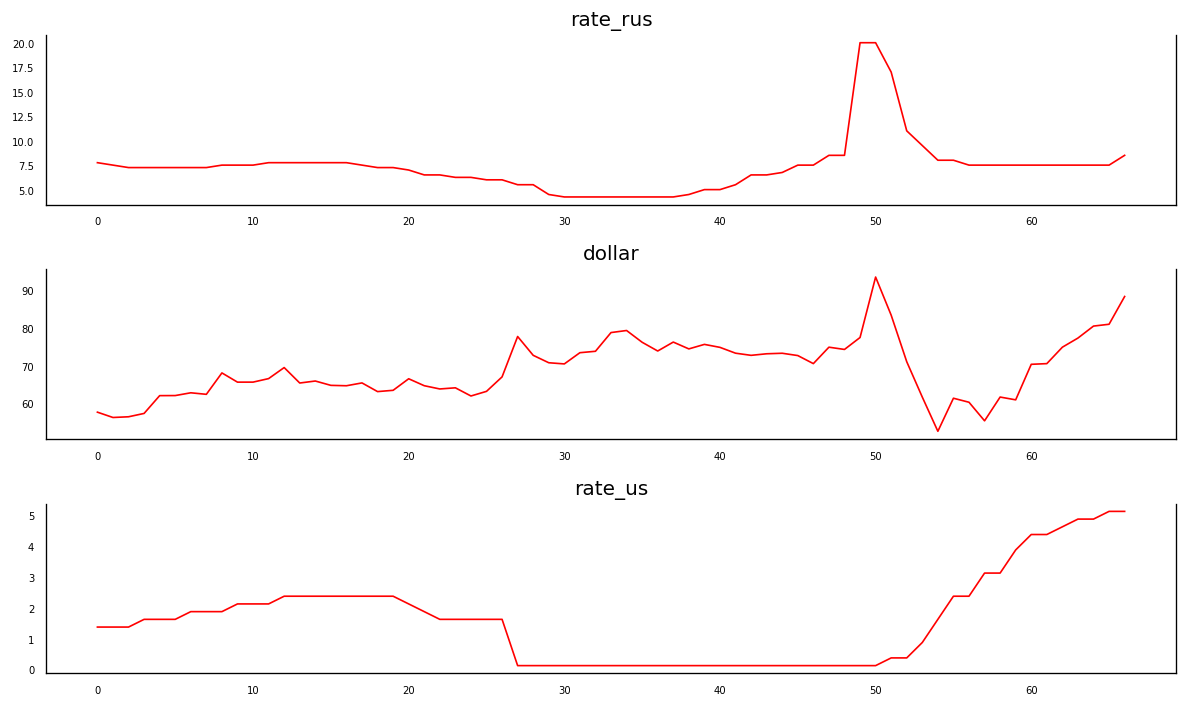

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since function

,rate_rus_x,dollar_x,rate_us_x
rate_rus_y,1.0000,0.3906,0.8669
dollar_y,0.0000,1.0000,0.0843
rate_us_y,0.0001,0.0329,1.0000


In [30]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 4)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rate_rus ::  20.67     > 24.2761   =>   False
dollar ::  5.99      > 12.3212   =>   False
rate_us ::  1.04      > 4.1296    =>   False


In [68]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(63, 3)
(4, 3)


In [70]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [72]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rate_rus" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9024
 No. Lags Chosen       = 1
 Critical value 1%     = -3.542
 Critical value 5%     = -2.91
 Critical value 10%    = -2.593
 => P-Value = 0.0451. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dollar" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6616
 No. Lags Chosen       = 0
 Critical value 1%     = -3.541
 Critical value 5%     = -2.909
 Critical value 10%    = -2.592
 => P-Value = 0.0809. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "rate_us" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [74]:
df_differenced = df_train.diff().dropna()

In [76]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rate_rus" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8795
 No. Lags Chosen       = 2
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dollar" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3886
 No. Lags Chosen       = 0
 Critical value 1%     = -3.542
 Critical value 5%     = -2.91
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "rate_us" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [78]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  1.2695066407562838
BIC :  1.6847605156756238
FPE :  3.561109038396426
HQIC:  1.4322485259739337 

Lag Order = 2
AIC :  1.4333057686050987
BIC :  2.166326365382834
FPE :  4.205982372022706
HQIC:  1.7200304211053656 

Lag Order = 3
AIC :  1.2636433154329252
BIC :  2.32001828691041
FPE :  3.573525996136929
HQIC:  1.676009320713209 

Lag Order = 4
AIC :  1.4282976690692746
BIC :  2.8137679692642803
FPE :  4.269608960353212
HQIC:  1.9679663331659514 

Lag Order = 5
AIC :  1.4461513543466826
BIC :  3.1666155798915674
FPE :  4.448660107334216
HQIC:  2.11478237955927 

Lag Order = 6
AIC :  1.6353799465324492
BIC :  3.6968986317450128
FPE :  5.581046276103281
HQIC:  2.4346263810722313 

Lag Order = 7
AIC :  1.7943986354545136
BIC :  4.203198457733479
FPE :  6.9329972036150265
HQIC:  2.7259009850338733 

Lag Order = 8
AIC :  1.7001829128511012
BIC :  4.462660755301483
FPE :  6.881668950313872
HQIC:  2.765562283845848 

Lag Order = 9
AIC :  1.5960196205097064
BIC :  4.7187464

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,2.174,2.289,8.796,2.218
1,1.788,2.247*,5.983,1.963*
2,1.926,2.729,6.900,2.232
3,1.728,2.875,5.721*,2.165
4,1.893,3.384,6.884,2.460
5,1.872,3.708,6.973,2.571
6,2.004,4.184,8.371,2.834
7,2.073,4.597,9.647,3.034
8,1.883,4.751,8.838,2.975
9,1.572,4.784,7.452,2.795


In [82]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Dec, 2024
Time:                     19:45:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.32002
Nobs:                     59.0000    HQIC:                   1.67601
Log likelihood:          -258.430    FPE:                    3.57353
AIC:                      1.26364    Det(Omega_mle):         2.23412
--------------------------------------------------------------------
Results for equation rate_rus
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.002382         0.240837            0.010           0.992
L1.rate_rus         0.164458         0.142208            1.156           0.247
L1.dollar          -0.020612         0.075279           -0.274   

In [84]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rate_rus : 1.94
dollar : 2.08
rate_us : 1.97


In [86]:
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[0.    , 9.4572, 0.5   ],
       [0.    , 0.1799, 0.    ],
       [0.    , 4.3758, 0.25  ]])

In [88]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rate_rus_2d,dollar_2d,rate_us_2d
63,-0.297219,1.036016,-0.014015
64,0.490480,0.905701,0.065287
65,0.087011,1.585588,0.025616
66,0.224106,0.682883,0.030123


In [90]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [98]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rate_rus_forecast', 'dollar_forecast', 'rate_us_forecast']]

,rate_rus_forecast,dollar_forecast,rate_us_forecast
63,7.202781,80.305016,4.860985
64,7.396041,86.622532,5.162258
65,7.676313,94.525636,5.489147
66,8.180690,103.111624,5.846159


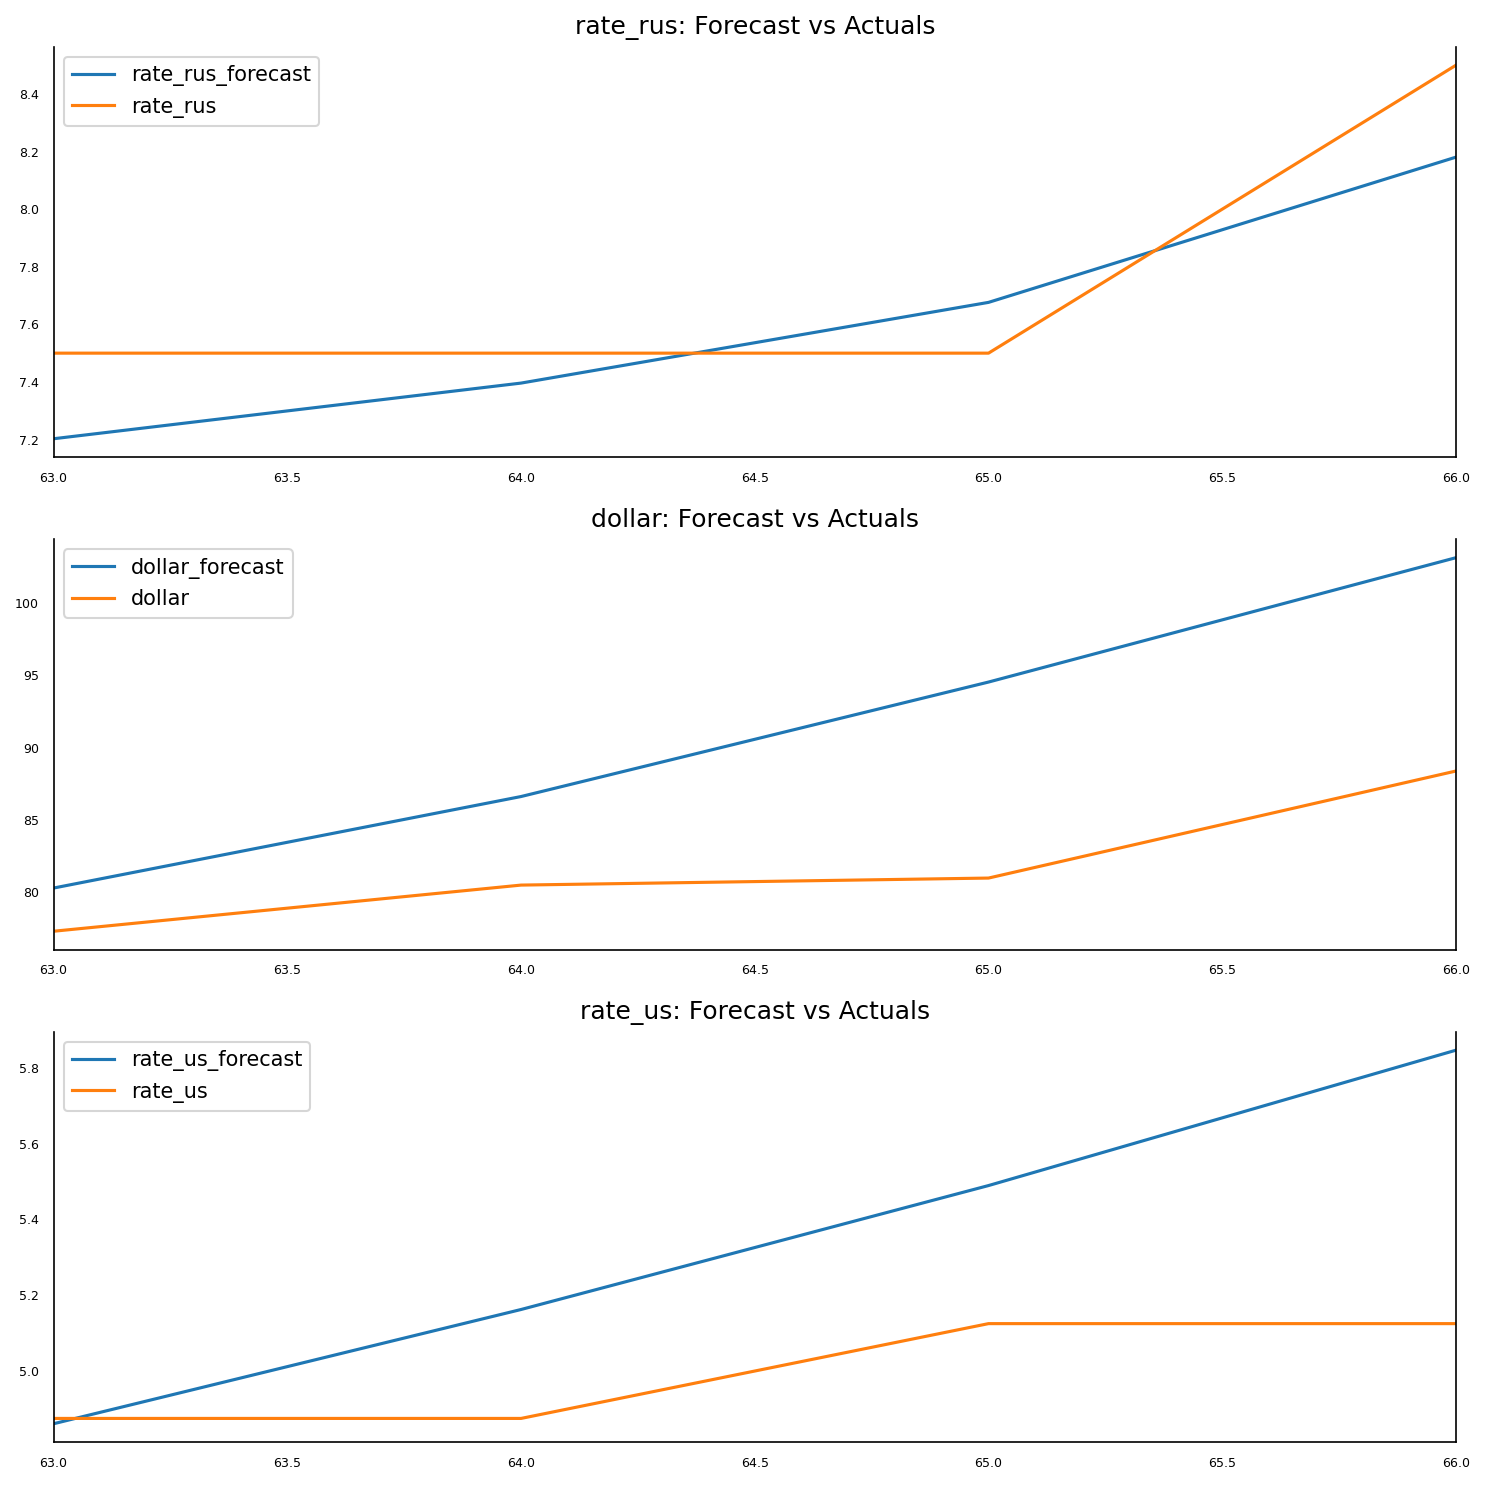

In [110]:
fig, axes = plt.subplots(nrows= 3, ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [114]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rate_rus')
accuracy_prod = forecast_accuracy(df_results['rate_rus_forecast'].values, df_test['rate_rus'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: dollar')
accuracy_prod = forecast_accuracy(df_results['dollar_forecast'].values, df_test['dollar'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: rate_us')
accuracy_prod = forecast_accuracy(df_results['rate_us_forecast'].values, df_test['rate_us'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: rate_rus
mape   :  0.0286
me     :  -0.136
mae    :  0.2242
mpe    :  -0.0169
rmse   :  0.2409
corr   :  0.8892
minmax :  0.0285

Forecast Accuracy of: dollar
mape   :  0.112
me     :  9.3384
mae    :  9.3384
mpe    :  0.112
rmse   :  10.5624
corr   :  0.9407
minmax :  0.0984

Forecast Accuracy of: rate_us
mape   :  0.0684
me     :  0.3396
mae    :  0.3466
mpe    :  0.067
rmse   :  0.4288
corr   :  0.8932
minmax :  0.0621
